# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 2:  $k$-NN and Linear Regression 

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

# <div class="theme"> Predicting Taxi Pickups in NYC </div>

In this homework, we will explore $k$-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York City at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

## <div class="exercise"> <b> Question 1  [13 pts]</b> </div>

**1.1 [2 pts]**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2 [3 pts]**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.

**1.3 [4 pts]**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4 [4 pts]**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.


### Answers

**1.1 [2 pts]. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.**

In [3]:
# read the file
cab_df = pd.read_csv("data/nyc_taxi.csv")
cab_df.head()

,TimeMin,PickupCount,Day
0,860,33,Fri
1,17,75,Sun
2,486,13,Sun
3,300,5,Thu
4,385,10,Thu


In [4]:
# split the data
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=109)
train_data.head()

,TimeMin,PickupCount,Day
346,749,32,Wed
1027,244,9,Fri
126,745,19,Mon
814,1177,54,Mon
908,833,43,Thu


**1.2 [3 pts]. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.**

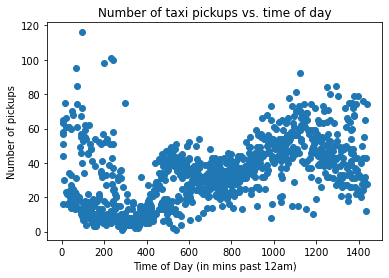

In [5]:
# create variables for test and training datasets
X_train = train_data[['TimeMin']]
y_train = train_data['PickupCount']

X_test = test_data[['TimeMin']]
y_test = test_data['PickupCount']

# plot relationship between TimeMin and PickupCount
plt.scatter(X_train, y_train)
plt.xlabel('Time of Day (in mins past 12am)')
plt.ylabel('Number of pickups')
plt.title('Number of taxi pickups vs. time of day');

**1.3 [4 pts]. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**



There appears to be a sinusoidal relation (S-shaped curve) between number of pickups and time of day over the course of the day with the pickups lowest around the 200-400min range (3:20am - 6:40am). Understandably, most people are at home sleeping and not many are out availing cab rides and about during this time so the lull makes sense. 

The pickup count has roughly two peaks - one during the 7-9am range and one during the 5-8pm range. This makes sense because we can assume the former peak is due to people going to work and the latter one accounting for people coming back from work. 

Lastly there is a decrease from 1100 minutes past to 1440 minutes past (to roughly initial position). This is reasonable as time of day is a periodic variable; it makes sense that the graph looks like it can wrap around to the beginning without there being a sharp changed (the pickup rate is roughly the same during 11pm-12am as it is from 12am-1am thus showing no break in continuity).

**1.4 [4 pts]. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.**

This is peak office hour for people trying to reach their offices by the traditional 9am start time during the weekdays. During weekdays, there is a morning rush, so there would likely be more than 30 pickups at around nine am, whereas during weekends, people would not need a taxi as early (<20 needed) and so it follows the general increasing trend. The hole is thus caused by the gap in taxi demand between weekdays and weekends.


In [6]:
display(train_data[(train_data.TimeMin < 550) & (train_data.TimeMin > 500) & ((train_data.Day == 'Sun') | (train_data.Day == 'Sat'))].describe())
print("Pickups on the weekend")
# mean pickup count is 11.8 and median is 12.5 for weekends 

display(train_data[(train_data.TimeMin < 550) & (train_data.TimeMin > 500) & (train_data.Day != 'Sun') & (train_data.Day != 'Sat')].describe())
print("Pickups on the weekdays")
# mean pickup count is 41.7 and median is 41 for weekdays

,TimeMin,PickupCount
count,14.000000,14.000000
mean,522.500000,11.857143
std,15.220179,6.175101
min,501.000000,1.000000
25%,511.000000,7.750000
50%,521.000000,12.500000
75%,537.250000,16.500000
max,546.000000,21.000000


Pickups on the weekend


,TimeMin,PickupCount
count,24.000000,24.000000
mean,526.541667,41.708333
std,14.823539,4.912089
min,501.000000,31.000000
25%,513.750000,38.750000
50%,529.500000,41.000000
75%,538.000000,44.750000
max,549.000000,51.000000


Pickups on the weekdays


## <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen $k$-Nearest Neighbors ($k$-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run $k$-NN Regression. 


**2.1 [4 pts]**. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2 [6 pts]**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3 [3 pts]**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4 [3 pts]**. Plot, in a single figure, the two 'curves' of $R^2$ values from the models on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5 [9 pts]**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

### Answers

**2.1 [4 pts]. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`).**


In [7]:
# Dictionary of different regressors
KNNModels = {}

# List of different k-values
k_list = [1,10,75,250,500,750,1000]

# Do a bunch of KNN regressions
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(X_train, y_train)
    # Store the regressors in a dictionary
    KNNModels[k] = knnreg 

# Print the dictionary
KNNModels


{1: KNeighborsRegressor(n_neighbors=1),
 10: KNeighborsRegressor(n_neighbors=10),
 75: KNeighborsRegressor(n_neighbors=75),
 250: KNeighborsRegressor(n_neighbors=250),
 500: KNeighborsRegressor(n_neighbors=500),
 750: KNeighborsRegressor(n_neighbors=750),
 1000: KNeighborsRegressor(n_neighbors=1000)}


**2.2 [5 pts].  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a line plot of predictions for `PickupCount` vs  a dummy `TimeMin` using `np.arange(np.min(train['TimeMin']),np.max(train['TimeMin']),1)`.  Do the same for the test set in separate plots.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set.** 

**Hints**:
1. Each subplot should use different color to distinguish k-NN regression prediction curve from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  

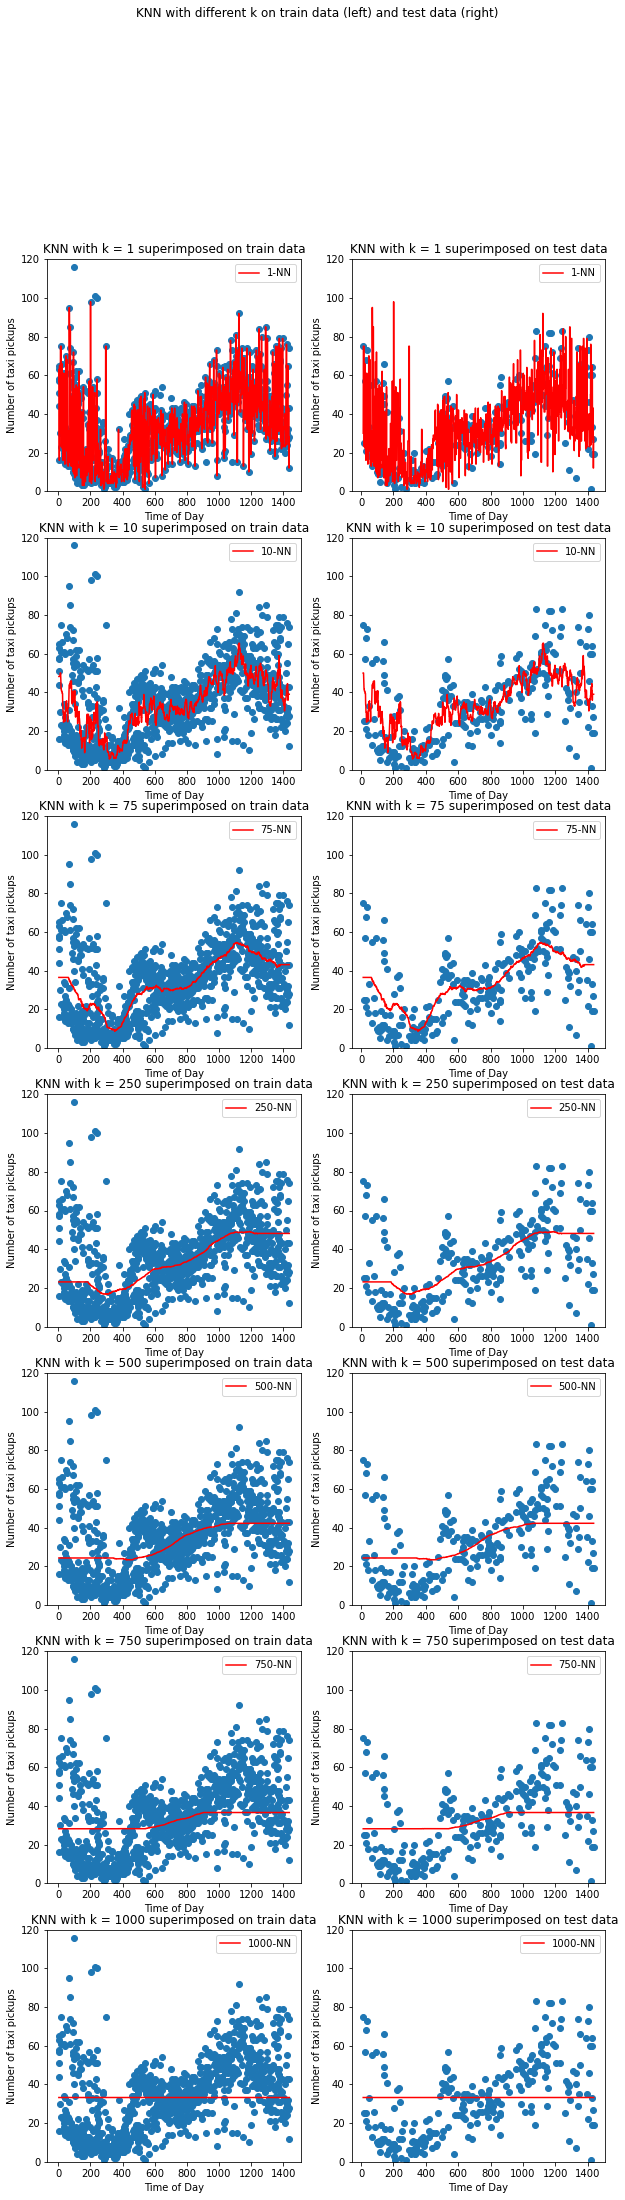

In [8]:
# initialize the figure and axes
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10,35))
X_grid_train = np.arange(np.min(train_data['TimeMin']), np.max(train_data['TimeMin']), 1).reshape(-1,1)
X_grid_test = np.arange(np.min(test_data['TimeMin']), np.max(test_data['TimeMin']), 1).reshape(-1,1)

for i, (k, model) in enumerate(KNNModels.items()):
    
    # create graphs for training data
    predictions = model.predict(X_grid_train) 
    axes[i, 0].plot(X_grid_train, predictions, color="red", label="{}-NN".format(k))
    axes[i, 0].scatter(X_train, y_train)
    axes[i, 0].set_ylim([0, 120])
    axes[i, 0].title.set_text(f'KNN with k = {k} superimposed on train data')
    axes[i, 0].set_xlabel('Time of Day')
    axes[i, 0].set_ylabel('Number of taxi pickups')
    axes[i, 0].legend()
    
    # create graphs for test data
    predictions = model.predict(X_grid_test) 
    axes[i, 1].plot(X_grid_test, predictions, color="red", label="{}-NN".format(k))
    axes[i, 1].scatter(X_test, y_test)
    axes[i, 1].set_ylim([0, 120])
    axes[i, 1].title.set_text(f'KNN with k = {k} superimposed on test data')
    axes[i, 1].set_xlabel('Time of Day')
    axes[i, 1].set_ylabel('Number of taxi pickups')
    axes[i, 1].legend()
    
fig.suptitle('KNN with different k on train data (left) and test data (right)')
plt.show()

**2.3 [3 pts]. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**



In [9]:
# your code here
r_squared_list = []

for k in k_list:
    r_squared_dict = {'k':k,'Training data': KNNModels[k].score(X_train, y_train), 'Test data': KNNModels[k].score(X_test, y_test)}
    r_squared_list.append(r_squared_dict)

print("R^2 score for the fitted models on the training and test set:")
pd.DataFrame(r_squared_list, columns = ['k','Training data','Test data'])


R^2 score for the fitted models on the training and test set:


,k,Training data,Test data
0,1,0.667533,-0.074464
1,10,0.469673,0.414593
2,75,0.418806,0.479658
3,250,0.343803,0.394991
4,500,0.276392,0.302357
5,750,0.169987,0.179605
6,1000,0.000000,-0.000032


**2.4 [3 pts]. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.



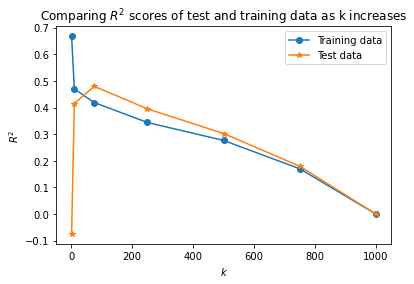

In [10]:
scores_train = [] # R2 scores for training data
scores_test = [] # R2 scores for testing data
for k in k_list:
    knnreg = KNNModels[k]
    
    # Calculate R^2 score for training data
    score_train = knnreg.score(X_train, y_train) 
    scores_train.append(score_train)
    
    # Calculate R^2 score for test data
    score_test = knnreg.score(X_test, y_test) 
    scores_test.append(score_test)

# Plot
fig, ax = plt.subplots(1,1)
ax.plot(k_list, scores_train,'o-',label='Training data')
ax.plot(k_list, scores_test,'*-', label='Test data')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')
ax.legend()
plt.title('Comparing $R^2$ scores of test and training data as k increases');


**2.5 [9 pts]. Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

It just takes the average of the whole dataset and uses the average to predict new values.

2. What does an $R^2$ score of $0$ mean?  

The model performs equally to a model predicting new values based on the mean of all values.

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

It's worse than the model predicting based on the average. Yes $R^2$ was negative for $k=1,1000$ for the `test_data`.

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

Yes, the $R^2$ for training data has a continuous downwards trend approaching 0. The test data has a hill shaped curve where it increases to a peak at $k=75$ and then follows a path similar to that of the training data as it approaches 0.

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

The best value of $k$ is 75. We chose this value based on the highest $R^2$ value in the `test_data`. Even though the $R^2$ values are higher for training data from $k=1$ to $k=25$ for the training data, we only care about the `test_data` since that is unseen data (so mimics what values the model would predict in the real world)  we want to test our model against.

The $R^2$ value of the `test_data` for $k=75$ is much higher than the $R^2$ for the `train_data` (nearly 0.48 compared to roughly 0.42).

6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

The mean squared error would show an upward trend in the case of the `train_data` (where the MSE for $k=1$ will be 0 or very close to it) while there would be a valley (a positive quadratic shape) for the `test_data`. So in a way flipping the $R^2$ graphs vertically would give us a rough idea of how the MSE plot would look like!

## <div class="exercise"> <b> Question 3 [23 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1 [3 pts]**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2 [3 pts]**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4 [2 pts]**. Report the estimates for the slope and intercept for the fitted linear model.

**3.5 [3 pts]**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6 [10 pts]**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know?
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers



**3.1 [3 pts]. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.**



In [11]:
import statsmodels.regression.linear_model as lm

X = sm.add_constant(X_train)
lin_reg_sm = lm.OLS(y_train, X)
OLSModel = lin_reg_sm.fit()
OLSModel.params

/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const      17.341910
TimeMin     0.022715
dtype: float64

**3.2 [3 pts]. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.**

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


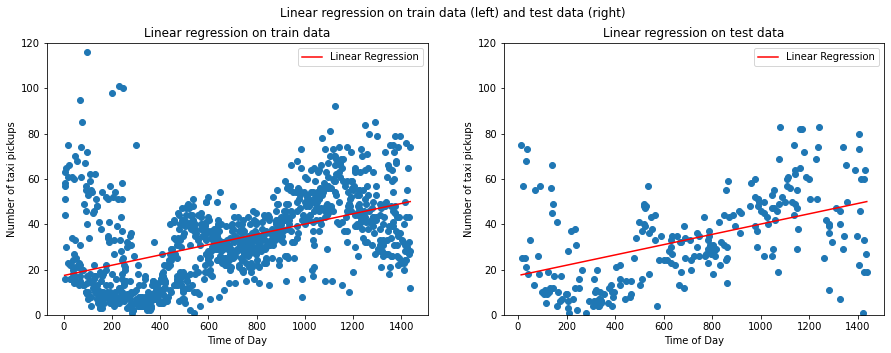

In [12]:
x_grid_train = X_grid_train.reshape(1,-1)[0]
x_grid_test = X_grid_test.reshape(1,-1)[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

predictions_train = OLSModel.params['const'] + OLSModel.params['TimeMin'] * x_grid_train
predictions_test = OLSModel.params['const'] + OLSModel.params['TimeMin'] * x_grid_test

axes[0].scatter(X_train, y_train)
axes[0].plot(X_grid_train, predictions_train, c="r", label="Linear Regression")

axes[1].scatter(X_test, y_test)
axes[1].plot(X_grid_test ,predictions_test, c="r", label="Linear Regression")

for i, data in enumerate(['train', 'test']):
    axes[i].set_ylim([0, 120])
    axes[i].title.set_text(f'Linear regression on {data} data')
    axes[i].set_xlabel('Time of Day')
    axes[i].set_ylabel('Number of taxi pickups')
    axes[i].legend(['Linear Regression'])
    
fig.suptitle('Linear regression on train data (left) and test data (right)')
plt.show()

**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.



In [13]:
yhat_train = OLSModel.params['const'] + OLSModel.params['TimeMin'] * train_data['TimeMin']
yhat_test = OLSModel.params['const'] + OLSModel.params['TimeMin'] * test_data['TimeMin']
print("R^2 scores for fitted models:")

r2_train = sk.metrics.r2_score(y_train, yhat_train)
print("Training set:  ", r2_train)

r2_test = sk.metrics.r2_score(y_test, yhat_test)
print("Test set:      ", r2_test)

R^2 scores for fitted models:
Training set:   0.23457707344420808
Test set:       0.27091642393405146


**3.4 [2 pts]. Report the estimates for the slope and intercept for the fitted linear model.**



In [14]:
beta0_sm = OLSModel.params[0]
beta1_sm = OLSModel.params[1]

print(f'The regression coef from statsmodels are:\nbeta_0 = {beta0_sm:8.6f} \nbeta_1 = {beta1_sm:8.6f}')

The regression coef from statsmodels are:
beta_0 = 17.341910 
beta_1 = 0.022715


**3.5 [3 pts]. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 



In [15]:
OLSModel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     305.9
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           6.06e-60
Time:                        23:03:52   Log-Likelihood:                -4225.3
No. Observations:                1000   AIC:                             8455.
Df Residuals:                     998   BIC:                             8464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3419      1.050     16.519      0.000      15.282      19.402
TimeMin        0.0227      0.001     17.489      0.000       0.020       0.025
==============================================================================
Omnibus:                      231.966   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.753
Skew:                           1.202   Prob(JB):                    3.53e-131
Kurtosis:                       5.939   Cond. No.                     1.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Intercept, $\beta_0$, 95% confidence interval = $[15.282, 19.402]$ and slope, $\beta_1$ = $[0.020, 0.025]$

**3.6 [10 pts]. Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

The test  𝑅2R2  score of 0.27 is worse than the best test  𝑅2R2  value obtained with k-NN regression of 0.47. This is not surprising as we can see the data appears sinusoidal (and not linear), so a linear model is expected to perform worse in fitting the data (and is closer to a flat line model of just taking the average).

2. What does the sign of the slope of the fitted linear model convey about the data?  

The sign is positive, so it conveys that as time progresses from midnight, there will be more and more people using taxis. In fact, with each passing minute, it expects 0.02 more people to grab a taxi than the previous minute.

3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 

It does appear that there is a significant linear relationship  between number of taxi pickups and time of day, because the 95% confidence interval of the slope does not include 0. Thus, the model suggests that there is indeed a positive relationship.

The confidence interval of the intercept gives us a notion of the number of cab pickups at midnight of each day.

4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  

99% confidence intervals will have the same midpoint for slope and intercept, but will be wider. This is because confidence intervals are centered on the predicted value (and expand for 3 standard deviations on both sides for 99% and just 2 standard deviations for 95%). This makes the 99% interval wider.

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

Based on the data structure, we should have $x\approx0$ and $x\approx1440$ have the same predicted y-value as they are both midnight. However, this does not happen with our linear model, which suggests a linear model is not very appropriate for this data set.


## <div class="exercise"> <b> Question 4 [12 pts] </b></div>

We next consider investigating how the day of the week is associated with pickups to improve both the predictive accuracy of the models and help with more in depth interpretations.  We begin by using the non-parametric *k*-NN approach.   

**4.1 [2 pts]**. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday. 

**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.

**4.3 [3 pts]**. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot). 

**4.4 [4 pts]**. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.






### Answers


**4.1 [2 pts]. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday.** 



In [16]:
# your code here
train_data["Weekend"] = 1 * ((train_data['Day'] == "Sat") | (train_data["Day"] == "Sun"))
train_data.head()


test_data["Weekend"] = 1 * ((test_data['Day'] == "Sat") | (test_data["Day"] == "Sun"))
test_data.head()

/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,TimeMin,PickupCount,Day,Weekend
1052,486,34,Mon,0
916,420,13,Sat,1
284,1138,75,Sat,1
176,645,22,Thu,0
219,1140,62,Fri,0


**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.


In [17]:
knnreg75 = KNeighborsRegressor(n_neighbors=75)

# Needed to add number greater than (k-value + 1440), so picked 1600
# so that there was no effect from the edge of the Weekday data in the Weekend predictions.
train_data["InflatedWeekend"] = 1600 * train_data["Weekend"]
test_data["InflatedWeekend"] = 1600 * test_data["Weekend"]
knnreg75.fit(np.array(train_data[['TimeMin','InflatedWeekend']]).reshape(-1,2), train_data['PickupCount'])



/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KNeighborsRegressor(n_neighbors=75)

**4.3 [3 pts]. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot).**


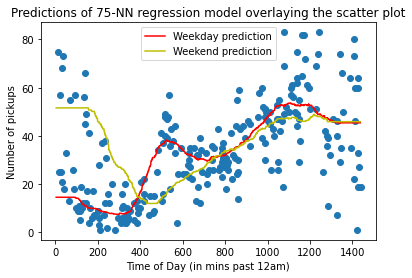

In [18]:
Xgrid_wday = pd.DataFrame(np.arange(np.min(train_data['TimeMin']), np.max(train_data['TimeMin']), 1), columns=["TimeMin"])
Xgrid_wday["InflatedWeekend"] = np.zeros((len(Xgrid_wday)), dtype=float)

Xgrid_wend = pd.DataFrame(np.arange(np.min(train_data['TimeMin']), np.max(train_data['TimeMin']), 1), columns=["TimeMin"])
Xgrid_wend["InflatedWeekend"] = 1600 * np.ones((len(Xgrid_wend)), dtype=float)

predictions_weekdays = knnreg75.predict(Xgrid_wday)
predictions_weekends = knnreg75.predict(Xgrid_wend)

plt.scatter(X_test, y_test)
plt.plot(Xgrid_wday['TimeMin'], predictions_weekdays, label="Weekday prediction", c='r');
plt.plot(Xgrid_wend['TimeMin'], predictions_weekends, label="Weekend prediction", c='y');
plt.xlabel('Time of Day (in mins past 12am)')
plt.ylabel('Number of pickups')
plt.title('Predictions of 75-NN regression model overlaying the scatter plot');
plt.legend();

# in this case we were not sure if we should overlay on test or train data. 
# we chose to overlay on the test data to see how the model performs on new data.


**4.4 [4 pts]. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.**


On one hand, for weekends, there is generally a dip between midnight and 10am before increasing a bit and plateauing. On the other hand, for weekdays, there is much more fluctuation. While following a general pattern of the weekends, it has peaks at 9am and 5pm (which are rush hours), so the trends make sense.
Also, it might be reasonable to assume that people usually go out on weekends (to parties, etc) and thus the cab pick up rate in the wee hours is higher than it is for weekdays. The weekend curve has a sluggish upwards trend towards early morning maybe because most people stay in.

##### <div class="exercise"> <b> Question 5 [27 pts] </b></div>

Finally we turn to multiple regression models to see if there is a weekend affect.  Note: Use sklearn to do the modeling unless otherwise stated.


**5.1 [6 pts]**. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.

**5.2 [6 pts]**. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.

**5.3 [3 pts]**. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.

**5.4 [4 pts]**. Determine if the model in 5.3 is a more accurate model than the *k*-NN model in 4.2.  Why do you suppose this is the case?

**5.5 [5 pts]**. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot of the training data). How does this compare to the plot from 4.3?

**5.6 [3 pts]**. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.

### Answers

**5.1 [6 pts]. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:**

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.


In [19]:
# your code here
X = sm.tools.add_constant(train_data[['TimeMin','Weekend']])
sm_multi_reg = sm.OLS(train_data['PickupCount'],X).fit()
sm_multi_reg.summary()

/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     164.4
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           1.93e-62
Time:                        23:04:43   Log-Likelihood:                -4216.4
No. Observations:                1000   AIC:                             8439.
Df Residuals:                     997   BIC:                             8454.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7475      1.107     14.220      0.000      13.574      17.921
TimeMin        0.0228      0.001     17.665      0.000       0.020       0.025
Weekend        4.6383      1.098      4.223      0.000       2.483       6.793
==============================================================================
Omnibus:                      183.150   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.494
Skew:                           1.008   Prob(JB):                     1.63e-90
Kurtosis:                       5.421   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The coefficient for `TimeMin` is 0.0228, which means with every extra one minute past midnight, there is expected to be a 0.0228 increase in number of pickups (fixing weekends). Likewise, the coefficient for `Weekend` is 4.6383, which means that by virtue of being a minute during the weekend, you can expect a 4.6383 increase in pickups compared to the same minute during the weekdays (fixing time past midnight). We can also see the coefficient for `TimeMin` in multiple regression is the about same for Linear Regression with just `TimeMin`. Thus, it appears that there is not much confounding with `TimeMin` (by adding the weekend variable) and that the general sign and magnitude of the trend holds regardless of Weekday or Weekend. 

Hypothesis Testing:
**First**, let the null hypothesis be that there is no significant relation between TimeMin and PickupCount. We see that the 95% confidence interval for the beta value for TimeMin is between 0.020 and 0.025. Since this does not include 0, we can reject the null hypothesis, and that there is likely a significant relation between TimeMin and PickupCount. Alternatively, since the p-value is 0.000 and we often use 0.05 as a cutoff, we can determine that the relation is statistically significant.

**Second**, let the null hypothesis be that there is no significant relation between Weekend and PickupCount. We see that the 95% confidence interval for the beta value for Weekend is between 2.483 and 6.793. Since this does not include 0, we can reject the null hypothesis, and that there is likely a significant relation between Weekend and PickupCount. Alternatively, since the p-value is 0.000 and we often use 0.05 as a cutoff, we can determine that the relation is statistically significant.


**5.2 [6 pts]. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.**



In [20]:
# trying to mimic `PolynomialFeatures`
def polynomial_features(order, X):
    X = np.array(X)
    for i in range(order+1):
        if i == 0 or i == 1:
            continue
        poly_term = np.array(X[:,0] ** i).reshape(-1,1)
        X = np.hstack((X, poly_term))
    return pd.DataFrame(X)

def polynomial_features_and_interaction(order, X, interaction_var):
    Y = np.array(polynomial_features(order, X))
    for i in range(order):
        interaction_term = np.array(Y[:,i] * interaction_var).reshape(-1,1)
        Y = np.hstack((Y, interaction_term))
    Y = np.hstack((Y, np.array(interaction_var).reshape(-1,1)))
    return pd.DataFrame(Y)

In [21]:
r2_list = []

for i in range(2, 7):
    r2_dict = {}
    transformed_X_train = polynomial_features(i, X_train, include_bias=False)
    fitted_model = LinearRegression().fit(transformed_X_train, y_train)
    
    transformed_X_test = polynomial_features(i, X_test)
    r2 = fitted_model.score(transformed_X_test, y_test)
    r2_dict[i] = r2
    r2_list.append(r2_dict)

print(r2_list)

[{2: 0.2797420802532561}, {3: 0.4204172737999097}, {4: 0.42374830469188085}, {5: 0.4402604559360149}, {6: 0.40961917112377944}]


Polynomial degree 5 had highest $R^2$ of $0.44$ so it is safe to conclude that this is the best model.

**5.3 [3 pts]. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.**


In [22]:
# create interaction variable for `train_data`
X_interact_train = polynomial_features_and_interaction(5, train_data[['TimeMin']], train_data['Weekend'])

# fit the model
poly_reg_model = LinearRegression().fit(X_interact_train, y_train)


**5.4 [4 pts]. Determine if the model in 5.3 is a more predictive model than the *k*-NN model in 4.2.  Why do you suppose this is the case?**



In [23]:
# create interaction variable for `test_data`
X_interact_test = polynomial_features_and_interaction(5, test_data[['TimeMin']], test_data['Weekend'])

In [24]:
r2_poly = poly_reg_model.score(X_interact_test, y_test)
r2_knn = knnreg75.score(np.array(test_data[['TimeMin','InflatedWeekend']]).reshape(-1,2), test_data['PickupCount'])

print("R^2 for polynomial regression model:", r2_poly)
print("R^2 for knn model:                  ", r2_knn)


R^2 for polynomial regression model: 0.5880979380516581
R^2 for knn model:                   0.6429717779802158


It appears through the $R^2$ that the polynomial regression is a less predictive model than kNN. This may be because the Weekend and Weekday data do not both fit best with the polynomial of degree 5 and there is instead some compromise when both are taken into account. However, with kNN, the data points are completely separated using the 1600 factor and thus the form of the model for weekday does not affect the form for the model for weekend and vice versa. Lastly, the kNN form is much more flexible than polynomial regression in capturing the oddities with rush hour and sleep schedules than a strict k-degree polynomial regression. In a way, this means that the data may inherently not have such a polynomial trend.

**5.5 [5 pts]. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot). How does this compare to the plot from 4.3?**



In [25]:
# transform weekday data to be fed to the model
xgrid_wday = pd.DataFrame(np.arange(np.min(test_data['TimeMin']), np.max(test_data['TimeMin']), 1), columns=["TimeMin"])
Xgrid_wday = polynomial_features_and_interaction(5, xgrid_wday, np.zeros(len(xgrid_wday)))


In [26]:
# transform weekend data to be fed to the model
xgrid_wend = pd.DataFrame(np.arange(np.min(test_data['TimeMin']), np.max(test_data['TimeMin']), 1), columns=["TimeMin"])
Xgrid_wend = polynomial_features_and_interaction(5, xgrid_wend, np.ones(len(xgrid_wend)))


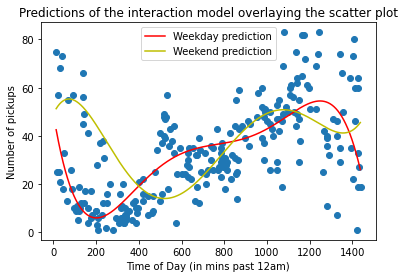

In [27]:
predictions_weekdays = poly_reg_model.predict(Xgrid_wday)
predictions_weekends = poly_reg_model.predict(Xgrid_wend)

plt.scatter(X_test, y_test)
plt.plot(xgrid_wday, predictions_weekdays, label="Weekday prediction", c='r');
plt.plot(xgrid_wend, predictions_weekends, label="Weekend prediction", c='y');
plt.xlabel('Time of Day (in mins past 12am)')
plt.ylabel('Number of pickups')
plt.title('Predictions of the interaction model overlaying the scatter plot');
plt.legend();

The graph looks much smoother than it was in 4.3 but it still follows a similar structure with the way the weekend pickup count drops during the 9am rush hour while there is a small peak in the weekday data at that time.

**5.6 [3 pts]. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.**

Including the weather information at each minute could also show us useful information. We could perhaps see the trends in data because of weather conditions (maybe sunny weather makes more people walk rather than taking the car; during a storm, we can see a steep rise in the number of cab pickups). This will help the model predict the number of pickups at any given minute more accurately given the weather information.